In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
       #  print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## To display the graphs within the code and not in another windows 
## To display the graphs within the code and not in another windows 
import sys
print("Python Version :"+str(sys.version_info))
%matplotlib inline
# To be able to use CSV
import csv
print("CSV Version :"+csv.__version__)
# To be able to use Numpy
import numpy as np
print("Numpy Version :"+np.__version__)
# To be able to use Pandas
import pandas as pd
print("Pandas Version :"+pd.__version__)
# To be able to use Maplotlib
import matplotlib.pyplot as plt

# To be able to use Seaborn
import seaborn as sns
print("Seaborn Version :"+sns.__version__)


# import scipy as sio
# print("Scipy Version :"+sio.__version__)
import scipy.io as sio
import os
import shutil
import random
import cv2 as cv

print("OpenCV Version : "+cv.__version__)


from PIL import Image

# To be able to use Warning
import warnings
import sklearn
print("Sklearn Version : "+sklearn.__version__)
from sklearn.cluster import MiniBatchKMeans
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import catboost
import time
print("Catboost Version : "+catboost.__version__)
from catboost import CatBoostClassifier




from keras.preprocessing.image import load_img, img_to_array
from keras.applications.xception import preprocess_input
from keras.applications import *
from keras.applications.xception import decode_predictions
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,MaxPooling2D, Input
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import *
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Concatenate, Conv2D, Flatten, MaxPooling2D
from keras.layers import BatchNormalization, Dropout, GlobalMaxPooling2D
from keras.models import Model
print("Keras Version : "+tf.keras.__version__)
print("Tensorflow Version : "+tf.__version__)


Python Version :sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
CSV Version :1.0
Numpy Version :1.18.5
Pandas Version :1.1.0
Seaborn Version :0.10.0
OpenCV Version : 4.3.0
Sklearn Version : 0.23.2
Catboost Version : 0.24
Keras Version : 2.4.0
Tensorflow Version : 2.3.0


In [2]:
images_directory = '/kaggle/input/mydogs/'
train_directory = '/kaggle/input/mydogs/train/'
test_directory = '/kaggle/input/mydogs/test/'
main_categories = [directory for directory in os.listdir(train_directory)]
main_categories.sort()
batch_size = 2

In [3]:
class MixupImageDataGenerator():
    def __init__(self, generator, directory, batch_size, img_height, img_width, alpha=0.2, subset=None):
        """Constructor for mixup image data generator.
        Arguments:
            generator {object} -- An instance of Keras ImageDataGenerator.
            directory {str} -- Image directory.
            batch_size {int} -- Batch size.
            img_height {int} -- Image height in pixels.
            img_width {int} -- Image width in pixels.
        Keyword Arguments:
            alpha {float} -- Mixup beta distribution alpha parameter. (default: {0.2})
            subset {str} -- 'training' or 'validation' if validation_split is specified in
            `generator` (ImageDataGenerator).(default: {None})
        """

        self.batch_index = 0
        self.batch_size = batch_size
        self.alpha = alpha

        # First iterator yielding tuples of (x, y)
        self.generator1 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Second iterator yielding tuples of (x, y)
        self.generator2 = generator.flow_from_directory(directory,
                                                        target_size=(
                                                            img_height, img_width),
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        subset=subset)

        # Number of images across all classes in image directory.
        self.n = self.generator1.samples

    def reset_index(self):
        """Reset the generator indexes array.
        """

        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def on_epoch_end(self):
        self.reset_index()

    def reset(self):
        self.batch_index = 0

    def __len__(self):
        # round up
        return (self.n + self.batch_size - 1) // self.batch_size

    def get_steps_per_epoch(self):
        """Get number of steps per epoch based on batch size and
        number of images.
        Returns:
            int -- steps per epoch.
        """

        return self.n // self.batch_size

    def __next__(self):
        """Get next batch input/output pair.
        Returns:
            tuple -- batch of input/output pair, (inputs, outputs).
        """

        if self.batch_index == 0:
            self.reset_index()

        current_index = (self.batch_index * self.batch_size) % self.n
        if self.n > current_index + self.batch_size:
            self.batch_index += 1
        else:
            self.batch_index = 0

        # random sample the lambda value from beta distribution.
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)

        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        # Get a pair of inputs and outputs from two iterators.
        X1, y1 = self.generator1.next()
        X2, y2 = self.generator2.next()

        # Perform the mixup.
        X = X1 * X_l + X2 * (1 - X_l)
        y = y1 * y_l + y2 * (1 - y_l)
        return X, y

    def __iter__(self):
        while True:
            yield next(self)

In [4]:
main_categories

['Affenpinscher',
 'AfghanHound',
 'AfricanHuntingDog',
 'Airedale',
 'AmericanStaffordshireTerrier',
 'Appenzeller',
 'AustralianTerrier',
 'Basenji',
 'Basset',
 'Beagle',
 'BedlingtonTerrier',
 'BerneseMountainDog',
 'Black',
 'BlenheimSpaniel',
 'Bloodhound',
 'Bluetick',
 'BorderCollie',
 'BorderTerrier',
 'Borzoi',
 'BostonBull',
 'BouvierDesFlandres',
 'Boxer',
 'BrabanconGriffon',
 'Briard',
 'BrittanySpaniel',
 'BullMastiff',
 'Cairn',
 'Cardigan',
 'ChesapeakeBayRetriever',
 'Chihuahua',
 'Chow',
 'Clumber',
 'CockerSpaniel',
 'Collie',
 'Curly',
 'DandieDinmont',
 'Dhole',
 'Dingo',
 'Doberman',
 'EnglishFoxhound',
 'EnglishSetter',
 'EnglishSpringer',
 'Entlebucher',
 'EskimoDog',
 'Flat',
 'FrenchBulldog',
 'GermanShepherd',
 'GermanShort',
 'GiantSchnauzer',
 'GoldenRetriever',
 'GordonSetter',
 'GreatDane',
 'GreatPyrenees',
 'GreaterSwissMountainDog',
 'Groenendael',
 'IbizanHound',
 'IrishSetter',
 'IrishTerrier',
 'IrishWaterSpaniel',
 'IrishWolfhound',
 'ItalianGreyh

In [5]:
# train_datagen1 = ImageDataGenerator(rescale=1. / 255, validation_split=0.2)
transformation_ratio = .05
train_datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=transformation_ratio, shear_range=transformation_ratio, zoom_range=transformation_ratio, cval=transformation_ratio, horizontal_flip=True, vertical_flip=True, validation_split=0.2)


In [6]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [7]:
train_generator = MixupImageDataGenerator(generator=train_datagen,
                                          directory=train_directory,
                                          batch_size=batch_size,
                                          img_height=224,
                                          img_width=224,
                                          subset='training')

validation_generator = train_datagen.flow_from_directory(train_directory, target_size=(224, 224), batch_size=batch_size, class_mode='categorical', classes=main_categories, subset='validation', shuffle=True)

Found 11664 images belonging to 120 classes.
Found 11664 images belonging to 120 classes.
Found 2853 images belonging to 120 classes.


In [8]:
test_generator = test_datagen.flow_from_directory(test_directory, target_size=(224, 224), batch_size=batch_size, class_mode='categorical', classes=main_categories, shuffle=False)

Found 6063 images belonging to 120 classes.


In [9]:
# model = Sequential()
# model.add(Conv2D(filters = 16, kernel_size = 2,input_shape=(224,224,3),padding='same'))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Conv2D(filters = 32,kernel_size = 2,activation= 'relu',padding='same'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Conv2D(filters = 64,kernel_size = 2,activation= 'relu',padding='same'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Conv2D(filters = 128,kernel_size = 2,activation= 'relu',padding='same'))
# model.add(MaxPooling2D(pool_size=2))

# model.add(Dropout(0.3))
# model.add(Flatten())
# model.add(Dense(150))
#model.add(Activation('relu'))
# model.add(Dropout(0.4))

model = Sequential()
#pic_input = Input(shape=(224, 224, 3))
#ang_input = Input(shape=(1,))
#merge = concatenate([pic_input,ang_input])
#model.add(Conv2D(filters = 16, kernel_size =(3, 3), input_shape=[(224, 224, 3), (1, )], activation='relu'))
model.add(Conv2D(filters = 16, kernel_size =(3, 3), input_shape=(224, 224, 3), activation='relu'))
model.add(Conv2D(filters = 16, kernel_size =(3, 3),  activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters =  32, kernel_size =(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 64,kernel_size = (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 128, kernel_size =(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters = 256, kernel_size =(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(filters = 16, kernel_size = 2, input_shape=(224, 224, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters =  32, kernel_size = 2, activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters = 64,kernel_size = 2, activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters = 128, kernel_size = 2, activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv2D(filters = 256, kernel_size = 2, activation='relu'))
# model.add(MaxPooling2D(pool_size=2))


model.add(Flatten())  # this converts our 2D feature maps to 1D feature vectors
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))

model.add(Dense(len(main_categories),activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0

In [10]:
train_generator.reset()
validation_generator.reset()
# model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])
model.compile(loss="categorical_crossentropy",  optimizer=Adam(learning_rate=0.0001), metrics=["accuracy"])

In [11]:
earlystopping = EarlyStopping(monitor ="val_loss",  
                                        mode ="min", patience = 5,  
                                        restore_best_weights = True) 

In [12]:
start_time = time.time()

In [13]:
model_info = model.fit_generator(train_generator, validation_data=validation_generator, epochs=30, verbose=2, callbacks =[earlystopping], steps_per_epoch=train_generator.get_steps_per_epoch(), validation_steps=validation_generator.samples // batch_size)

Epoch 1/30
5832/5832 - 383s - loss: 4.7856 - accuracy: 0.0117 - val_loss: 4.7670 - val_accuracy: 0.0151
Epoch 2/30
5832/5832 - 359s - loss: 4.6553 - accuracy: 0.0226 - val_loss: 4.5008 - val_accuracy: 0.0291
Epoch 3/30
5832/5832 - 361s - loss: 4.4503 - accuracy: 0.0406 - val_loss: 4.3526 - val_accuracy: 0.0456
Epoch 4/30
5832/5832 - 361s - loss: 4.3249 - accuracy: 0.0542 - val_loss: 4.2639 - val_accuracy: 0.0519
Epoch 5/30
5832/5832 - 364s - loss: 4.2248 - accuracy: 0.0728 - val_loss: 4.1418 - val_accuracy: 0.0729
Epoch 6/30
5832/5832 - 366s - loss: 4.1534 - accuracy: 0.0845 - val_loss: 4.0720 - val_accuracy: 0.0863
Epoch 7/30
5832/5832 - 365s - loss: 4.0563 - accuracy: 0.0967 - val_loss: 4.0422 - val_accuracy: 0.0929
Epoch 8/30
5832/5832 - 367s - loss: 3.9684 - accuracy: 0.1140 - val_loss: 3.9766 - val_accuracy: 0.1066
Epoch 9/30
5832/5832 - 370s - loss: 3.9001 - accuracy: 0.1312 - val_loss: 3.9213 - val_accuracy: 0.1031
Epoch 10/30
5832/5832 - 367s - loss: 3.8151 - accuracy: 0.1405 -

In [14]:
print("Time:"+ (str)(time.time()-start_time))

Time:8495.230179548264


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


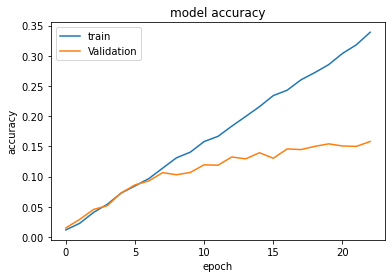

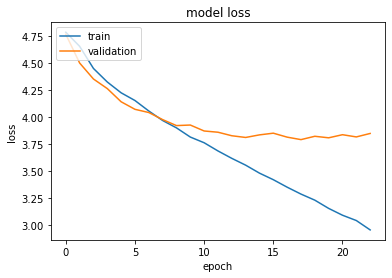

In [15]:
# list all data in history
print(model_info.history.keys())
# summarize history for accuracy
plt.plot(model_info.history['accuracy'])
plt.plot(model_info.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
validation_generator.reset()
score = model.evaluate_generator(validation_generator, (validation_generator.samples + (batch_size - 1)) // batch_size)
print("For validation data set; Loss: ", score[0], " Accuracy: ", score[1])

For validation data set; Loss:  3.7875208854675293  Accuracy:  0.15036803483963013


In [17]:
test_generator.reset()
score = model.evaluate_generator(test_generator, (test_generator.samples + (batch_size-1)) // batch_size)
print("For test data set; Loss: ",score[0]," Accuracy: ", score[1])

For test data set; Loss:  3.7872376441955566  Accuracy:  0.14283357560634613


In [18]:
test_generator.reset()

testStep = (test_generator.samples + (batch_size-1)) // batch_size
print("testStep: ", testStep)

testStep:  3032


In [19]:
Y_pred = model.predict_generator(test_generator, steps=testStep, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
print(str(len(y_pred)))
labels = (validation_generator.class_indices)
print("Labels "+(str)(labels))
labels = dict((v, k) for k, v in labels.items())
print(labels)
predictedLabels = [labels[k] for k in y_pred]
print("Predicted Labels "+(str)(predictedLabels))
len(predictedLabels)
actualLabels = [labels[k] for k in test_generator.classes]
print("Actual Labels "+(str)(actualLabels))
len(actualLabels)

3032/3032 - 26s
[ 83  62  62 ...   6   3 102]
6063
Labels {'Affenpinscher': 0, 'AfghanHound': 1, 'AfricanHuntingDog': 2, 'Airedale': 3, 'AmericanStaffordshireTerrier': 4, 'Appenzeller': 5, 'AustralianTerrier': 6, 'Basenji': 7, 'Basset': 8, 'Beagle': 9, 'BedlingtonTerrier': 10, 'BerneseMountainDog': 11, 'Black': 12, 'BlenheimSpaniel': 13, 'Bloodhound': 14, 'Bluetick': 15, 'BorderCollie': 16, 'BorderTerrier': 17, 'Borzoi': 18, 'BostonBull': 19, 'BouvierDesFlandres': 20, 'Boxer': 21, 'BrabanconGriffon': 22, 'Briard': 23, 'BrittanySpaniel': 24, 'BullMastiff': 25, 'Cairn': 26, 'Cardigan': 27, 'ChesapeakeBayRetriever': 28, 'Chihuahua': 29, 'Chow': 30, 'Clumber': 31, 'CockerSpaniel': 32, 'Collie': 33, 'Curly': 34, 'DandieDinmont': 35, 'Dhole': 36, 'Dingo': 37, 'Doberman': 38, 'EnglishFoxhound': 39, 'EnglishSetter': 40, 'EnglishSpringer': 41, 'Entlebucher': 42, 'EskimoDog': 43, 'Flat': 44, 'FrenchBulldog': 45, 'GermanShepherd': 46, 'GermanShort': 47, 'GiantSchnauzer': 48, 'GoldenRetriever': 49

6063

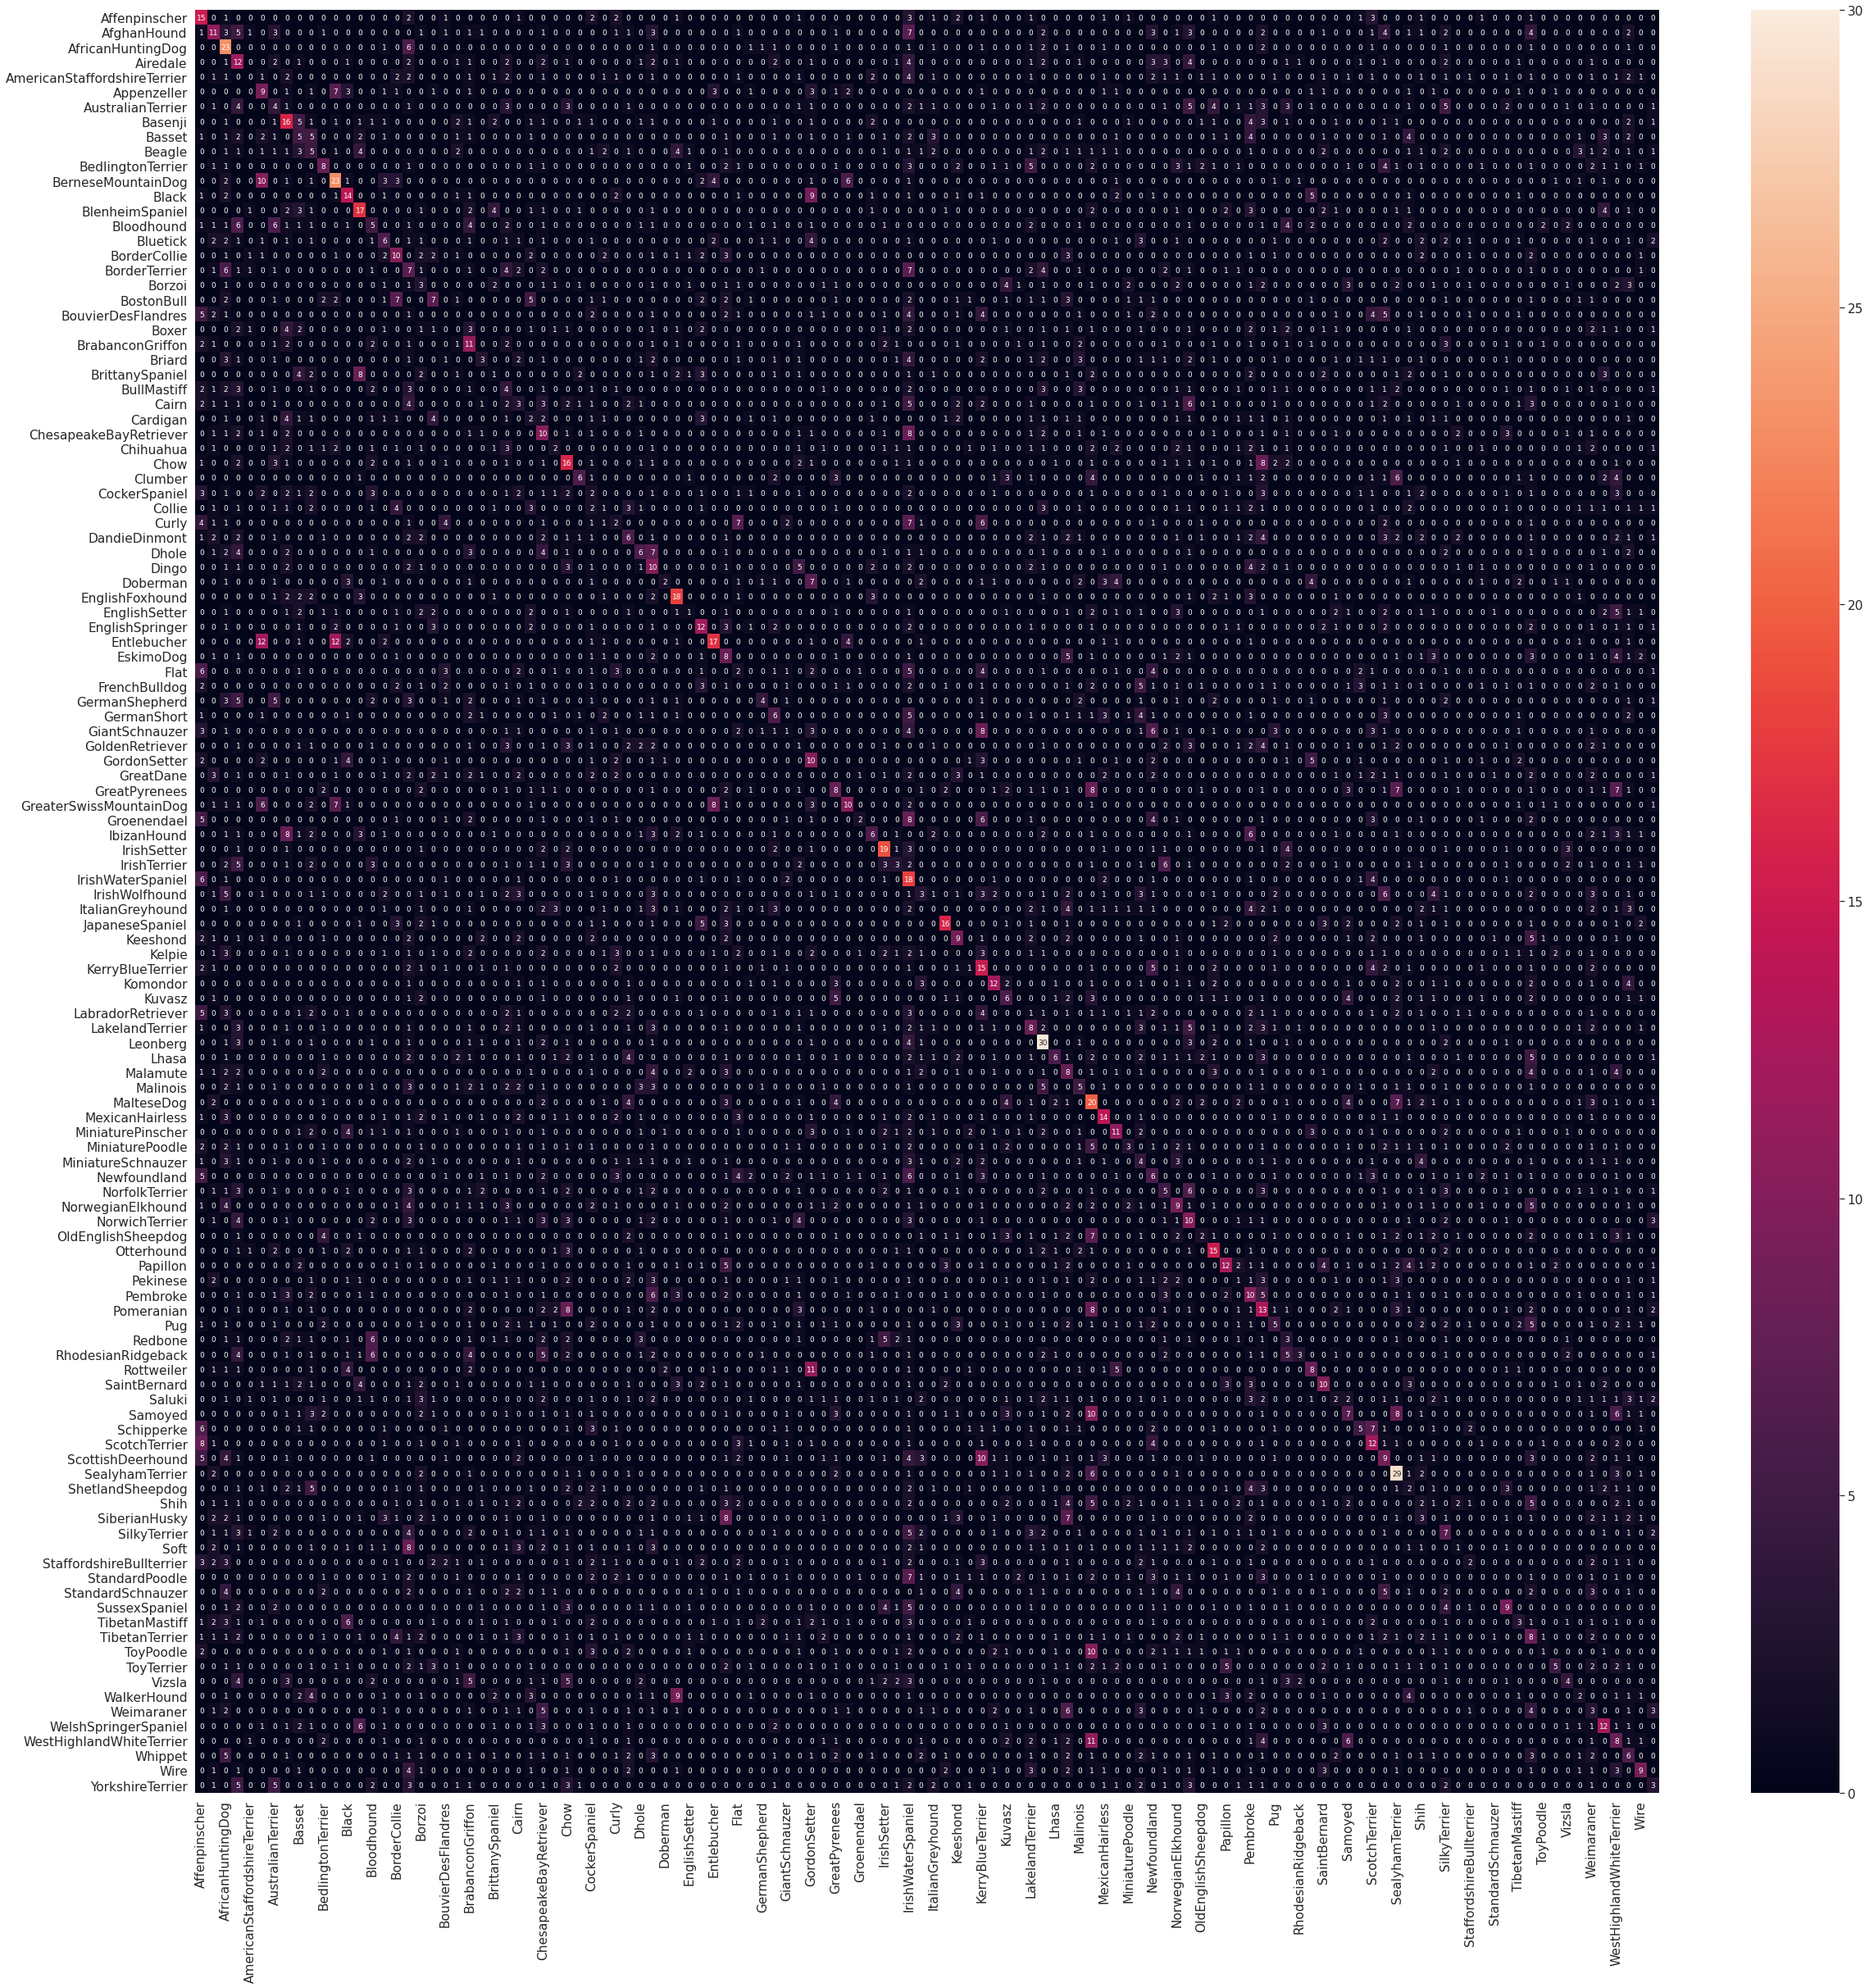

In [22]:
df_cm = pd.DataFrame(confusion_matrix(actualLabels, predictedLabels), main_categories, main_categories)
plt.figure(figsize=(40,40))
sns.set(font_scale=1.4) # for label size
# sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size
plt.show()

In [21]:
print(classification_report(actualLabels, predictedLabels))

                              precision    recall  f1-score   support

               Affenpinscher       0.13      0.34      0.19        44
                 AfghanHound       0.17      0.15      0.16        71
           AfricanHuntingDog       0.16      0.46      0.24        50
                    Airedale       0.10      0.20      0.13        60
AmericanStaffordshireTerrier       0.00      0.00      0.00        48
                 Appenzeller       0.16      0.20      0.18        44
           AustralianTerrier       0.07      0.07      0.07        58
                     Basenji       0.19      0.26      0.22        62
                      Basset       0.10      0.10      0.10        52
                      Beagle       0.08      0.09      0.08        58
           BedlingtonTerrier       0.19      0.15      0.17        54
          BerneseMountainDog       0.37      0.36      0.36        64
                       Black       0.26      0.30      0.28        47
             Blenhe